In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
from utils import get_ray_directions, get_rays
import os
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from dataset import LegoDataset

/home/stanley/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# class LegoDataset(Dataset):
    def __init__(
        self,
        root_dir,
        split="train",
        img_shape=(800, 800),
        white_background=True,
    ):
        assert img_shape[0] == img_shape[1], "image width must equal image height"

        self.tn = 2.0
        self.tf = 6.0

        self.root_dir = root_dir
        self.split = split
        self.img_shape = img_shape
        self.white_background = white_background

        self.transform = transforms.ToTensor()
        self.read_meta_data()

    def read_meta_data(self):
        with open(
            os.path.join(self.root_dir, f"transforms_{self.split}.json"), "r"
        ) as file:
            self.meta = json.load(file)

        focal = 0.5 * 800 / np.tan(0.5 * self.meta["camera_angle_x"])
        focal *= self.img_shape[0] / 800

        self.directions = get_ray_directions(
            self.img_shape[0], self.img_shape[1], focal
        )  # [H, W, 3]

        if self.split == "train":
            self.all_rays_origin = []
            self.all_rays_direction = []
            self.all_rgbs = []

            for frame in self.meta["frames"]:
                camera2world = torch.FloatTensor(frame["transform_matrix"])[:3, :4]

                img_path = os.path.join(self.root_dir, f"{frame['file_path']}.png")
                img = Image.open(img_path)
                img = img.resize(self.img_shape, Image.LANCZOS)
                img = self.transform(img)  # [4, H, W]
                img = img.view(4, -1).permute(1, 0)  # [H*W, 4] RGBA
                img = img[:, :3] * img[:, -1:] + (1 - img[:, -1:])  # Blend A to RGB

                rays_origin, rays_direction = get_rays(
                    self.img_shape[0], self.img_shape[1], self.directions, camera2world
                )

                self.all_rays_origin.append(rays_origin)
                self.all_rays_direction.append(rays_direction)
                self.all_rgbs.append(img)

    def __len__(self):
        if self.split == "val":
            return 1  # valid single image
        return len(self.meta["frames"])

    def __getitem__(self, idx):
        if self.split == "train":
            # Use data in buffers
            sample = {
                "rays_origin": self.all_rays_origin[idx],
                "rays_direction": self.all_rays_direction[idx],
                "rgbs": self.all_rgbs[idx],
            }
        else:
            # Create data for each image separately
            frame = self.meta["frames"][idx]
            camera2world = torch.FloatTensor(frame["transform_matrix"])[:3, :4]

            img_path = os.path.join(self.root_dir, f"{frame['file_path']}.png")
            img = Image.open(img_path)
            img = img.resize(self.img_shape, Image.LANCZOS)
            img = self.transform(img)  # [4, H, W]
            img = img.view(4, -1).permute(1, 0)  # [H*W, 4] RGBA
            img = img[:, :3] * img[:, -1:] + (1 - img[:, -1:])  # Blend A to RGB

            rays_origin, rays_direction = get_rays(
                self.img_shape[0], self.img_shape[1], self.directions, camera2world
            )

            sample = {
                "rays_origin": rays_origin,
                "rays_direction": rays_direction,
                "rgbs": img,
                "c2w": camera2world,
            }

        return sample

In [3]:
lego_dataset = LegoDataset(
    root_dir="dataset/lego/", split="train", img_shape=(800, 800)
)

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(rays_origin), torch.tensor(rays_direction)


In [4]:
len(lego_dataset)

100

In [5]:
lego_dataset[1]

{'rays_origin': tensor([[-1.3987,  3.5542,  1.2888],
         [-1.3987,  3.5542,  1.2888],
         [-1.3987,  3.5542,  1.2888],
         ...,
         [-1.3987,  3.5542,  1.2888],
         [-1.3987,  3.5542,  1.2888],
         [-1.3987,  3.5542,  1.2888]], dtype=torch.float64),
 'rays_direction': tensor([[ 0.6453, -0.7637,  0.0191],
         [ 0.6447, -0.7642,  0.0191],
         [ 0.6441, -0.7647,  0.0191],
         ...,
         [-0.0246, -0.8079, -0.5887],
         [-0.0253, -0.8080, -0.5886],
         [-0.0261, -0.8081, -0.5884]], dtype=torch.float64),
 'rgbs': tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]])}

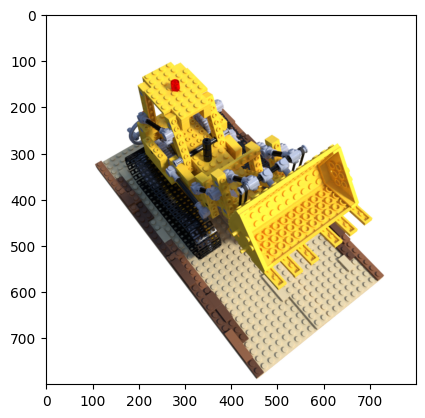

In [6]:
plt.imshow(lego_dataset[3]["rgbs"].reshape(800, 800, 3).numpy())